In [1]:
import requests
import os
import torch
import torchvision
import torchvision.transforms.v2 as transforms
from torchvision.datasets import ImageFolder
from torchmetrics import Precision, Recall
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50, ResNet50_Weights 
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
# def pull_images(card_range,url,save_path):
#         for card_num in tqdm(card_range):
#             #Change image url to fit file extension and tcg identifier
#             image_url = f'{url}{card_num:03}.jpg'
        
#             try:

#                 response = requests.get(image_url)
#                 response.raise_for_status()

#                 #Change image path to fit file extension and tcg identifier
#                 image_path = os.path.join(save_path,f'ltr-{card_num}.png')

#                 if response.status_code == 200:
#                     with open(image_path, 'wb') as f:
#                         f.write(response.content)
#                 else:
#                     print(f"Image not found or failed to download: {image_url} (Status code: {response.status_code})")

#             except requests.exceptions.HTTPError as err:
#                 print(f'Image not found: {image_url}')

In [3]:
#Split my images into train, test, val
# import splitfolders

# splitfolders.ratio(r'C:\Users\Wayne Ewing\Pictures\ComputerVision-Project\card_images\Real Life Images', output='card_splits', ratio=(.8,.1,.1))

Copying files: 1240 files [00:00, 1382.98 files/s]


In [4]:
transform = transforms.Compose([
                                # transforms.RandomRotation((-45,45)),
                                # transforms.RandomAutocontrast(), 
                                # transforms.GaussianBlur(3),
                                # transforms.Pad(10),
                                # transforms.RandomPerspective(),
                                transforms.ToImage(),
                                transforms.ToDtype(torch.float32, scale=True),
                                transforms.Resize((256,256))])

transform_test_val = transforms.Compose([transforms.ToImage(),
                                         transforms.ToDtype(torch.float32, scale=True),
                                         transforms.Resize((256,256))])

In [5]:
train_dataset = ImageFolder(r'C:\Users\Wayne Ewing\Pictures\ComputerVision-Project\card_splits\train', transform=transform)
val_dataset = ImageFolder(r'C:\Users\Wayne Ewing\Pictures\ComputerVision-Project\card_splits\val', transform=transform_test_val)
test_dataset = ImageFolder(r'C:\Users\Wayne Ewing\Pictures\ComputerVision-Project\card_splits\test', transform=transform_test_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
print(f"Number of images in train dataset: {len(train_dataset)}")
print(f"Number of images in validation dataset: {len(val_dataset)}")
print(f"Number of images in test dataset: {len(test_dataset)}")

print(f"Number of batches in train loader: {len(train_loader)}")
print(f"Batch size: {train_loader.batch_size}")

Number of images in train dataset: 992
Number of images in validation dataset: 124
Number of images in test dataset: 124
Number of batches in train loader: 31
Batch size: 32


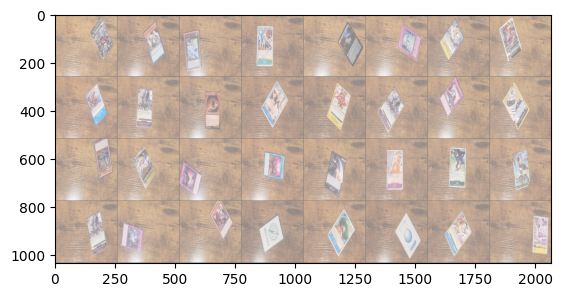

In [7]:
def imshow(img):
    img = img /2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

In [24]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
model = model.to(device)
model.fc = nn.Linear(model.fc.in_features, out_features=4)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0001)

In [25]:
def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Validation Loss: {val_loss/len(val_loader)}')
    print(f'validation Accuracy: {100 * correct / total}%')

def train_model(model, train_loader, criterion, optimizer, num_epochs=10, patience=5):
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # early_stopping = EarlyStopping(patience=patience, delta=0.001)
    model.to(device)
    
    for epoch in range(num_epochs):
        running_loss = 0.0

        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
        
        # # Validate the model
        # val_loss = validate_model(model, val_loader, criterion)

        # # Check early stopping
        # early_stopping(val_loss)
        # if early_stopping.early_stop:
        #     print("Early stopping triggered")
        #     break


def test_model(model, test_loader):
    model.to(device)
    model.eval()
    metric_precision = Precision(task='multiclass', num_classes=4, average=None)
    metric_recall = Recall(task='multiclass', num_classes=4, average=None)

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing', unit='batch'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predicted_cpu = predicted.cpu()
            labels_cpu = labels.cpu()
            metric_precision.update(predicted_cpu, labels_cpu)
            metric_recall.update(predicted_cpu, labels_cpu)
    precision = metric_precision.compute()
    recall = metric_recall.compute()
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")


In [26]:
train_model(model, train_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10: 100%|██████████| 31/31 [00:20<00:00,  1.48batch/s]


Epoch [1/10], Loss: 0.2354


Epoch 2/10: 100%|██████████| 31/31 [00:20<00:00,  1.49batch/s]


Epoch [2/10], Loss: 0.0096


Epoch 3/10: 100%|██████████| 31/31 [00:20<00:00,  1.48batch/s]


Epoch [3/10], Loss: 0.0051


Epoch 4/10: 100%|██████████| 31/31 [00:25<00:00,  1.24batch/s]


Epoch [4/10], Loss: 0.0061


Epoch 5/10: 100%|██████████| 31/31 [00:20<00:00,  1.49batch/s]


Epoch [5/10], Loss: 0.0061


Epoch 6/10: 100%|██████████| 31/31 [00:21<00:00,  1.47batch/s]


Epoch [6/10], Loss: 0.0027


Epoch 7/10: 100%|██████████| 31/31 [00:21<00:00,  1.47batch/s]


Epoch [7/10], Loss: 0.0013


Epoch 8/10: 100%|██████████| 31/31 [00:29<00:00,  1.05batch/s]


Epoch [8/10], Loss: 0.0009


Epoch 9/10: 100%|██████████| 31/31 [00:26<00:00,  1.18batch/s]


Epoch [9/10], Loss: 0.0005


Epoch 10/10: 100%|██████████| 31/31 [00:27<00:00,  1.11batch/s]

Epoch [10/10], Loss: 0.0003


In [27]:
test_model(model, test_loader)
print(test_dataset.class_to_idx)

Testing: 100%|██████████| 4/4 [00:04<00:00,  1.25s/batch]

Precision: tensor([1., 1., 1., 1.])
Recall: tensor([1., 1., 1., 1.])
{'digimon': 0, 'magic': 1, 'one piece': 2, 'yugioh': 3}


In [28]:
validate_model(model, val_loader, criterion)

Validation Loss: 0.000134918454932631
validation Accuracy: 100.0%


In [30]:
def save_model(model, optimizer, file_path):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, file_path)
    print(f"Model saved to {file_path}")

# Example usage
save_model(model, optimizer, r'C:\Users\Wayne Ewing\Pictures\ComputerVision-Project\model\trained_model.pt')

Model saved to C:\Users\Wayne Ewing\Pictures\ComputerVision-Project\model\trained_model.pt


In [15]:
# Step 1: Load the checkpoint
checkpoint = torch.load(r"C:\Users\Wayne Ewing\Pictures\ComputerVision-Project\model\trained_model.pt")

# Step 2: Initialize the model architecture (ResNet50 in this case)
model = resnet50(pretrained=False)

# Step 3: Modify the `fc` layer to have the same output size as in the checkpoint (4 classes)
# Change the final fully connected layer to match the checkpoint
num_classes = 4  # Adjust to the number of classes in your original task
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# Step 4: Load the state_dict from the checkpoint
model.load_state_dict(checkpoint['model_state_dict'])

# Step 5: Set the model to evaluation mode (if you're doing inference)
model.eval()

C:\Users\Wayne Ewing\AppData\Local\Temp\ipykernel_43764\2007341766.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(r"C:\Users\Wayne Ewing\Picture

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
model.eval()

transform = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Resize((256,256))
])

# IP camera URL (from your phone's IP webcam app)
url = "http://192.168.1.161:8080/video"  # Replace with your actual URL

# Open the video stream
cap = cv2.VideoCapture(url)

# counter = 1
# # Class names (same order as in training)
classes = ['digimon', 'magic', 'one piece', 'yugioh']  # Replace with your actual class names

while True:
    ret, frame = cap.read()
    
    if not ret:
        print("Failed to capture image")
        break
    
    # Display the video feed
    cv2.imshow('Camera Feed', frame)
    
    key = cv2.waitKey(1) & 0xFF
    
    # Predict when the spacebar is pressed
    if key == ord(' '):
        # filepath = f'C:\\Users\\Wayne Ewing\\Pictures\\ComputerVision-Project\\card_images\\Real Life Images\\digimon\\captured_frame_back{counter}.jpg'
        # cv2.imwrite(filepath, frame)
        # print(f"Frame captured and saved as '{filepath}.jpg'")
        # counter+=1
        image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        image = transform(image)
        image = image.unsqueeze(0)
        with torch.no_grad():
            outputs = model(image)
            _, predicted = torch.max(outputs, 1)
        predicted_class = classes[predicted.item()]
        print(f'Prediction: {predicted_class}')
        cv2.putText(frame, f'Prediction: {predicted_class}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.imshow('Video Feed', frame)
    
    if key == ord('q'):
        break

# Release the video capture and close windows
cap.release()
cv2.destroyAllWindows()

Prediction: one piece
Prediction: one piece
Prediction: yugioh
Prediction: magic
Prediction: magic
Prediction: one piece
Prediction: one piece
Prediction: yugioh
Prediction: one piece
Prediction: one piece
Prediction: one piece
Prediction: magic
Prediction: magic
Prediction: one piece
Prediction: digimon
Prediction: one piece
Prediction: magic
Prediction: yugioh
